In [1]:
import json
import numpy as np
from pathlib import Path
import sys
import os
import yaml
import pandas as pd
import pickle

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc
import xfields as xf
import xdeps as xd
import scipy
import gc
import io 
#import psutil

from IPython import embed

from xcoll.interaction_record.interaction_types import shortcuts
import pymadx
from xcoll_plotting import plot_functions as xcp
import matplotlib.pyplot as plt
import matplotlib


No pytransport functionality
No pytransport functionality


In [2]:
line_file = os.path.expandvars("${HOME_TWOCRYST}/MD_Energy_Ramp/track_injection_b2.json")
coll_file = os.path.expandvars("${HOME_TWOCRYST}/MD_Energy_Ramp/collimators_MD.yaml ")
sim_dict = os.path.expandvars("${HOME_TWOCRYST}/MD_Energy_Ramp/MD_dict.json")

In [3]:
normalized_emittance = 3.5e-6  



print('\nInput files:\n', line_file, '\n', coll_file, '\n')

if coll_file.endswith('.yaml'):
    with open(coll_file, 'r') as stream:
        coll_dict = yaml.safe_load(stream)['collimators']['b'+config_dict['run']['beam']]

en = 1000
energy = f'{en}'
with open(sim_dict, 'r') as f:
    data = json.load(f)

part_energy = data[energy]['energy'] 
gaps = data[energy]['gap']


line = xt.Line.from_json(line_file)
line.particle_ref = xt.Particles(p0c=part_energy, #eV
                                q0=1, mass0=xt.PROTON_MASS_EV)
print(f'\nParticle energy: {float(line.particle_ref.p0c)/1e9:} GeV\n')

end_s = line.get_length()

CRY_name ='tcpch.a5r7.b2'
TCP_name = 'tcp.d6r7.b2'
LIN_name = 'tcsg.b4r7.b2'

dx = 0
CRY_loc = line.get_s_position()[line.element_names.index(CRY_name)]
TCP_loc = line.get_s_position()[line.element_names.index(TCP_name)]
LIN_loc = line.get_s_position()[line.element_names.index(LIN_name)]
tw = line.twiss()

with open(sim_dict, 'r') as f:
    data = json.load(f)


Input files:
 /afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/MD_Energy_Ramp/track_injection_b2.json 
 /afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/MD_Energy_Ramp/collimators_MD.yaml  



Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           

Particle energy: 999.6599731445312 GeV



In [4]:
# ------------ PLOTTING FUNCT and LINES ----------------

def change_coordinates_to_b1(df):
    if 's' in df.columns:
        df['s'] = end_s - df['s']
    else:
        new_index = [end_s - i for i in df.index.values]
        df.index = new_index 
    return df

def reset_coord_cry_tracking_CRY(df, twiss):
    df['s'] = np.where(df['s'] <=  end_s-CRY_loc, end_s-CRY_loc-df['s'], 2*end_s-CRY_loc-df['s'])
    names = twiss.to_pandas().name.to_numpy()
    idx = np.where(names == CRY_name)[0][0]
    names = np.roll(names, -idx)
    df['name'] = names
    df = df.sort_values(by="s")
    return df

def get_jaw(name, length, n_env, emittance, tw, end_s, hgap = None,  color = 'r'):
    s_centre = end_s - tw['s', name]
    if hgap is None:
        hgap = n_env*np.sqrt(emittance*tw['betx', name])
    sstart  = s_centre - length/2
    send    = s_centre + length/2
    w       = send-sstart
    top_lim = plt.ylim()[1]*2
    bot_lim = plt.ylim()[0]*2
    h       = top_lim - hgap
    jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                            fc=color, ec=color, zorder=10)
    return jaw

def rad_to_deg(n):
    return n*180/np.pi

def convert_m_to_mm(val):
    return val / 1e-3

def convert_mm_to_m(val):
    return val * 1e-3

def extract_channelled(df):
    df = df.loc[(df['s']<=end_s-CRY_loc) & (df['s']>=end_s-LIN_loc)]
    return df

In [5]:
line_aper =  xt.Line.from_json("../input_files/2023_Run3_flat_top/flat_top_b2.json")
df_apertures = xcp.load_apertures(line_aper)
df_apertures = change_coordinates_to_b1(df_apertures)
layout_file = "../input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs"  
layout_data_object = pymadx.Data.Tfs(layout_file)

Loading line from dict:   0%|          | 0/105797 [00:00<?, ?it/s]

Done loading line from dict.           
pymadx.Tfs.Load> normal file


In [6]:
def CRY_kick(gap, energy, element, tw = tw):

    mp = 0.9382e9
    emittance_n = 3.5e-6
    gamma = energy/mp
    beta = np.sqrt(1-1/(gamma*gamma))
    emittance = emittance_n/(beta*gamma)

    beta_x = tw['betx', element]
    alpha_x = tw['alfx', element]

    #print('beta_y = ', beta_y, 'alpha_y = ', alpha_y)
    return gap*np.sqrt(emittance*beta_x), -gap*alpha_x*np.sqrt(emittance/beta_x)

In [36]:
CRY_bending_radious = 80.00
CRY_length = 0.004
CRY_bending_angle =  CRY_length/CRY_bending_radious


In [42]:
def plot_LS_dynamics(eng,  data = data, plot = True, tw = tw, line = line, save = False, start = 19950 , stop = 20150):
 
    energy = data[str(eng)]['energy']
    n_env = data[str(eng)]['gap'][CRY_name]
    mp = 0.9382e9
    emittance_n = 3.5e-6
    gamma = energy/mp
    beta = np.sqrt(1-1/(gamma*gamma))
    emittance = emittance_n/(beta*gamma)

    dp = 1.92e-10 
    pot_crit = 21.34
    eta = 0.9
    bending_radius = CRY_length/CRY_bending_angle
    Rcrit = energy/(2*np.sqrt(eta)*pot_crit) * (dp/2)
    CRY_critical_angle = np.sqrt(2*eta*pot_crit/energy)*(1 - Rcrit/bending_radius)

    context = xo.ContextCpu() 
    cry_part_chann = xp.Particles(p0c=energy, #eV
                            q0=1, mass0=xp.PROTON_MASS_EV,
                            y=0,
                            py=0,
                            x = CRY_kick(n_env, energy, CRY_name, tw)[0],
                            px = CRY_kick(n_env, energy, CRY_name,  tw)[1] + CRY_bending_angle,
                            _context=context)
    
    cry_part_chann_upper = xp.Particles(p0c=energy, #eV
                            q0 = 1, mass0=xp.PROTON_MASS_EV,
                            y = 0,
                            py = 0,
                            x = CRY_kick(n_env, energy, CRY_name, tw)[0],
                            px = CRY_kick(n_env, energy, CRY_name, tw)[1] + CRY_bending_angle + CRY_critical_angle,
                            _context=context)


    cry_part_chann_lower = xp.Particles(p0c=energy, #eV
                            q0 = 1, mass0=xp.PROTON_MASS_EV,
                            y = 0,
                            py = 0,
                            x = CRY_kick(n_env, energy, CRY_name, tw)[0],
                            px = CRY_kick(n_env, energy, CRY_name, tw)[1] + CRY_bending_angle - CRY_critical_angle,
                            _context=context)
    
    dech = xp.Particles(p0c=energy, #eV
                            q0 = 1, mass0=xp.PROTON_MASS_EV,
                            y = 0,
                            py = 0,
                            x = CRY_kick(n_env, energy, CRY_name, tw)[0],
                            px = CRY_kick(n_env, energy, CRY_name, tw)[1] + CRY_bending_angle/2,
                            _context=context)

    line.track(cry_part_chann, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=CRY_name)
    df_chann = reset_coord_cry_tracking_CRY(pd.DataFrame(list(zip(line.record_last_track.s[0], line.record_last_track.x[0], line.record_last_track.y[0], line.record_last_track.py[0])), columns =['s', 'x', 'y', 'py']), tw)
    df_chann = extract_channelled(df_chann)


    line.track(cry_part_chann_upper, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=CRY_name)
    df_chann_upper = reset_coord_cry_tracking_CRY(pd.DataFrame(list(zip(line.record_last_track.s[0], line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), tw)
    df_chann_upper = extract_channelled(df_chann_upper)

    line.track(cry_part_chann_lower, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=CRY_name)
    df_chann_lower = reset_coord_cry_tracking_CRY(pd.DataFrame(list(zip(line.record_last_track.s[0], line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), tw)
    df_chann_lower = extract_channelled(df_chann_lower)

    line.track(dech, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=CRY_name)
    df_dech = reset_coord_cry_tracking_CRY(pd.DataFrame(list(zip(line.record_last_track.s[0], line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), tw)
    df_dech = extract_channelled(df_dech)

    print('n envelope: ', n_env)
    print('Peak of channelled in x: ', df_chann[df_chann.name == LIN_name].x.iloc[0],' m')


    if plot:
        fig, ax_BLM = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(10,7))
        pymadx.Plot._SetMachineAxesStyle(ax_BLM[0])
        pymadx.Plot._DrawMachineLattice(ax_BLM[0], layout_data_object)
        ax_BLM[0].set_xlim(start,stop)

        df_ref = change_coordinates_to_b1(tw.to_pandas())
        ax_BLM[1].plot(df_ref["s"], df_ref["x"],color="orange")
        ax_BLM[1].plot(df_ref["s"], n_env*np.sqrt(emittance*df_ref['betx']), color='C1')
        ax_BLM[1].plot(df_ref["s"],-n_env*np.sqrt(emittance*df_ref['betx']), color='C1')
        ax_BLM[1].fill_between(df_ref["s"], n_env*np.sqrt(emittance*df_ref['betx']), -n_env*np.sqrt(emittance*df_ref['betx']), color='C1', alpha=0.3)

        ax_BLM[1].plot(df_chann["s"],df_chann["x"], color='darkblue')
        ax_BLM[1].plot(df_chann_upper["s"],df_chann_upper["x"], color='blue')
        ax_BLM[1].plot(df_chann_lower["s"],df_chann_lower["x"], color='blue')
        ax_BLM[1].fill_between(df_chann["s"], df_chann_upper["x"],df_chann_lower["x"], color='blue', alpha=0.3)

        ax_BLM[1].plot(df_dech["s"],df_dech["x"], color='green')
        ax_BLM[1].fill_between(df_dech["s"],  df_dech["x"], df_chann_lower["x"], color='green', alpha=0.3)

        ax_BLM[1].set_xlabel('s [m]',  fontsize=17)
        ax_BLM[1].set_xlim(start, stop)
        ax_BLM[1].set_ylim(-0.02, 0.04)
        ax_BLM[1].set_ylabel('x [m]',  fontsize=17)
        ax_BLM[1].grid(linestyle=':')
        ax_BLM[1].tick_params(axis='both', which='major', labelsize=17)
        xcp.plot_apertures(df_apertures[['xmin', 'xmax', 'ymin', 'ymax']].apply(lambda x: convert_mm_to_m(x)), ax_BLM[1], "h")

        ax_BLM[1].add_patch(get_jaw(LIN_name, 1, n_env, emittance,  tw, end_s, color='k'))
        ax_BLM[1].add_patch(get_jaw(CRY_name, 0.004, n_env, emittance,  tw, end_s))

        if save:
            plt.savefig('../Plots/BLMs_TCCP_{}sig_{}GeV.png'.format(n_env, round(energy/1e9)), dpi=300)
            
    return 

n envelope:  6.036649592386475
Peak of channelled in x:  0.008869295993146753  m


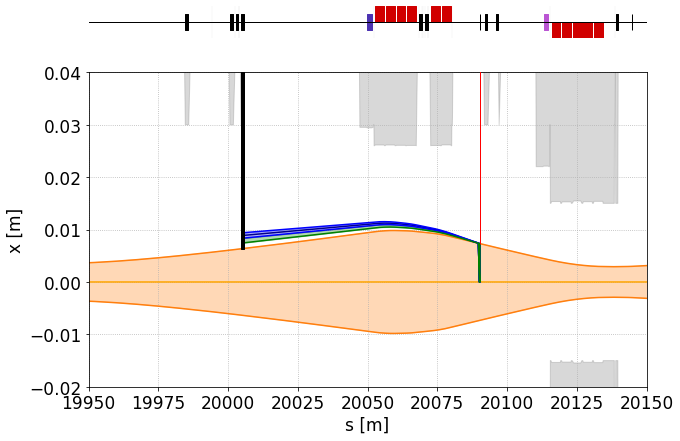

In [43]:
plot_LS_dynamics(450, save=False)

n envelope:  6.110539165670246
Peak of channelled in x:  0.00693896932574124  m


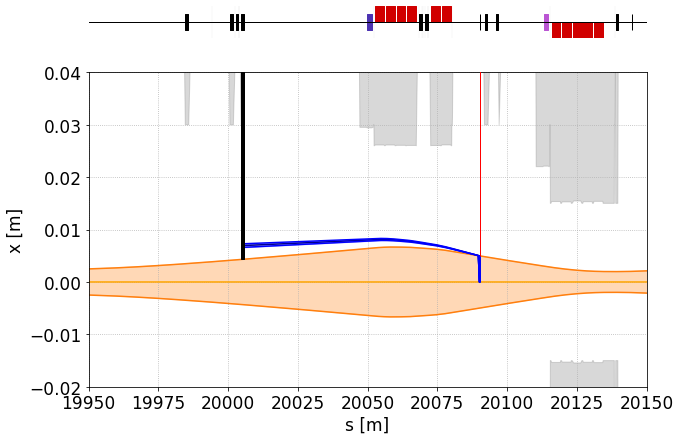

In [30]:
plot_LS_dynamics(1000, save=False)

n envelope:  6.037553799481403
Peak of channelled in x:  0.00518546647519729  m


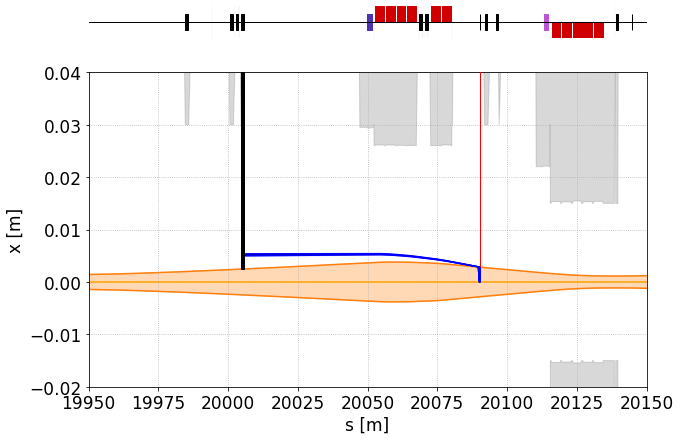

In [33]:
plot_LS_dynamics(3000, save=False)

n envelope:  6.059729345799786
Peak of channelled in x:  0.004667274456339068  m


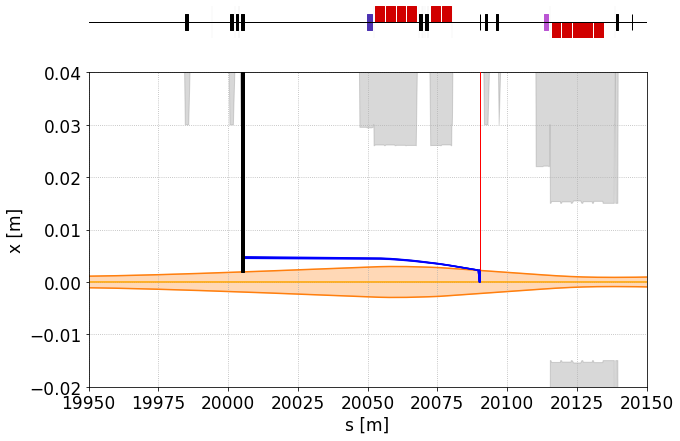

In [32]:
plot_LS_dynamics(5000, save=False)

In [ ]:
450
Mean:  0.0088810872583279  
Sigma:  0.0002607149231721351 

1000
Mean:  0.006939690858775296 
Sigma:  0.0001717598709508704 

3000
Mean:  0.005175003509387147 
Sigma:  9.421127749586289e-05 

5000
Mean:  0.004654539715295892 
Sigma:  6.780073026049329e-05 